<a href="https://colab.research.google.com/github/maliarabaci/tutorial/blob/main/cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, make sure you have PyTorch installed. You can install it using:

In [1]:
pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# Training a Classifier

Let's begin!

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [4]:
batch_size_val = 32
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_val, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_val, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 43615289.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



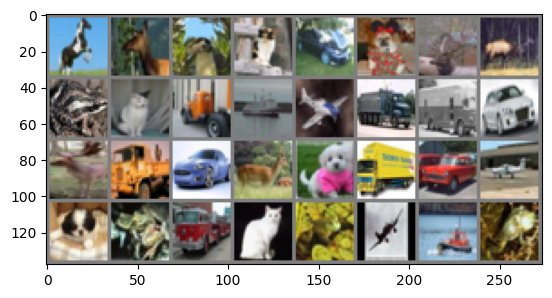

horse deer  bird  cat   car   dog   deer  deer  frog  cat   truck ship  plane truck truck car   deer  truck car   deer  dog   truck car   plane dog   frog  truck cat   frog  plane ship  frog 


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(images))))

### Step 3: Define the CNN Model

We'll create a function that takes the number of hidden layers, kernel size, optimizer, and activation function as arguments and defines the CNN architecture accordingly.


In [8]:
class Net(nn.Module):
    def __init__(self, kernel_size_val, activation_func):
        super(Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=kernel_size_val, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size_val, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7* 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = activation_func(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = activation_func(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 32 * 7* 7)
        x = activation_func(self.fc1(x))
        x = self.fc2(x)
        return x

kernel_size_val = 4
activation_func = nn.ReLU()
net = Net(kernel_size_val, activation_func)
net.to(device)
print(summary(net,(3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 31, 31]             784
            Conv2d-2           [-1, 32, 14, 14]           8,224
            Linear-3                  [-1, 128]         200,832
            Linear-4                   [-1, 10]           1,290
Total params: 211,130
Trainable params: 211,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.17
Params size (MB): 0.81
Estimated Total Size (MB): 0.98
----------------------------------------------------------------
None


### Step 4: Train and Evaluate ###

We'll define a function to train and evaluate the model with different configurations.

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [11]:
# @title
nof_epochs = 5

loss_values_epoch = np.zeros(nof_epochs)

for epoch in range(nof_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_values_epoch[epoch] += loss.item()
        if i % 200 == 199:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}")
            running_loss = 0.0

loss_values_epoch /= len(trainset)

print("Finished Training")

[1,   200] loss: 1.859
[1,   400] loss: 1.532
[1,   600] loss: 1.402
[1,   800] loss: 1.361
[1,  1000] loss: 1.289
[1,  1200] loss: 1.229
[1,  1400] loss: 1.182
[2,   200] loss: 1.088
[2,   400] loss: 1.042
[2,   600] loss: 1.041
[2,   800] loss: 1.038
[2,  1000] loss: 1.006
[2,  1200] loss: 0.975
[2,  1400] loss: 0.972
[3,   200] loss: 0.902
[3,   400] loss: 0.883
[3,   600] loss: 0.878
[3,   800] loss: 0.851
[3,  1000] loss: 0.849
[3,  1200] loss: 0.859
[3,  1400] loss: 0.856
[4,   200] loss: 0.756
[4,   400] loss: 0.789
[4,   600] loss: 0.775
[4,   800] loss: 0.759
[4,  1000] loss: 0.766
[4,  1200] loss: 0.763
[4,  1400] loss: 0.776
[5,   200] loss: 0.664
[5,   400] loss: 0.707
[5,   600] loss: 0.676
[5,   800] loss: 0.689
[5,  1000] loss: 0.690
[5,  1200] loss: 0.702
[5,  1400] loss: 0.691
Finished Training


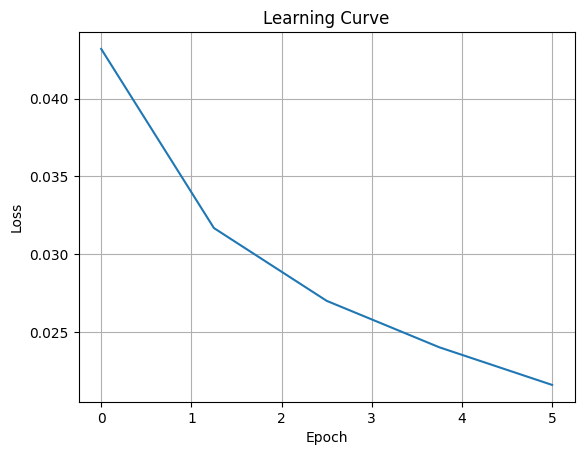

In [12]:
#PLOT THE LEARNING CURVE
iterations = np.linspace(0,nof_epochs, nof_epochs)
plt.plot(iterations, loss_values_epoch)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('on')

Let's quickly save our trained model:



In [13]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



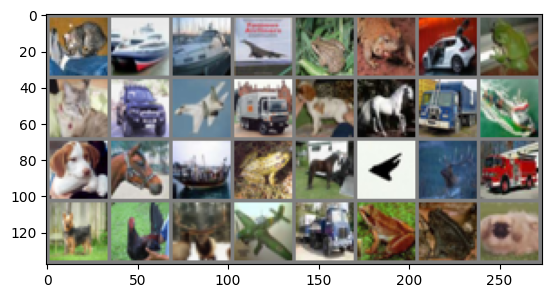

GroundTruth:  cat   ship  ship  plane


In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [15]:
net = Net(kernel_size_val, activation_func)
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Okay, now let us see what the neural network thinks these examples above are:



In [16]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 70 %


Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [19]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 74.8 %
Accuracy for class: car   is 81.9 %
Accuracy for class: bird  is 63.6 %
Accuracy for class: cat   is 40.0 %
Accuracy for class: deer  is 65.0 %
Accuracy for class: dog   is 71.3 %
Accuracy for class: frog  is 72.9 %
Accuracy for class: horse is 74.9 %
Accuracy for class: ship  is 81.1 %
Accuracy for class: truck is 77.0 %


In [20]:
del dataiter